# `CNRatioModel` Tutorial

Trey V. Wenger (c) December 2024

`CNRatioModel` models both ${\rm CN}$ and $^{13}{\rm CN}$ spectral simultaneously in order to constrain the isotopic ratio $^{12}{\rm C}/^{13}{\rm C}$.

The ratio parameter `12C_13C_ratio` is only equivalent to the "true" isotopic ratio under the assumption that both species have the same excitation conditions (i.e., the same population fraction in the $N=0$ and $N=1$ states). This parameter is equivalent to the total column density ratio of all $N=0$ and $N=1$ states, $N_{\rm tot, CN}/N_{{\rm tot}, ^{13}\rm CN}$ where $N_{\rm tot} = \sum N_{N=0} + N_{N=1}$.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+7.gdcf859e.dirty


## Simulate Data

12CN-1 450
12CN-2 300
13CN-1 250
13CN-2 250

Tex_12CN
[[3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]]

Tex_13CN
[[3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]
 [3.98107171 5.01187234]]

tau_12CN

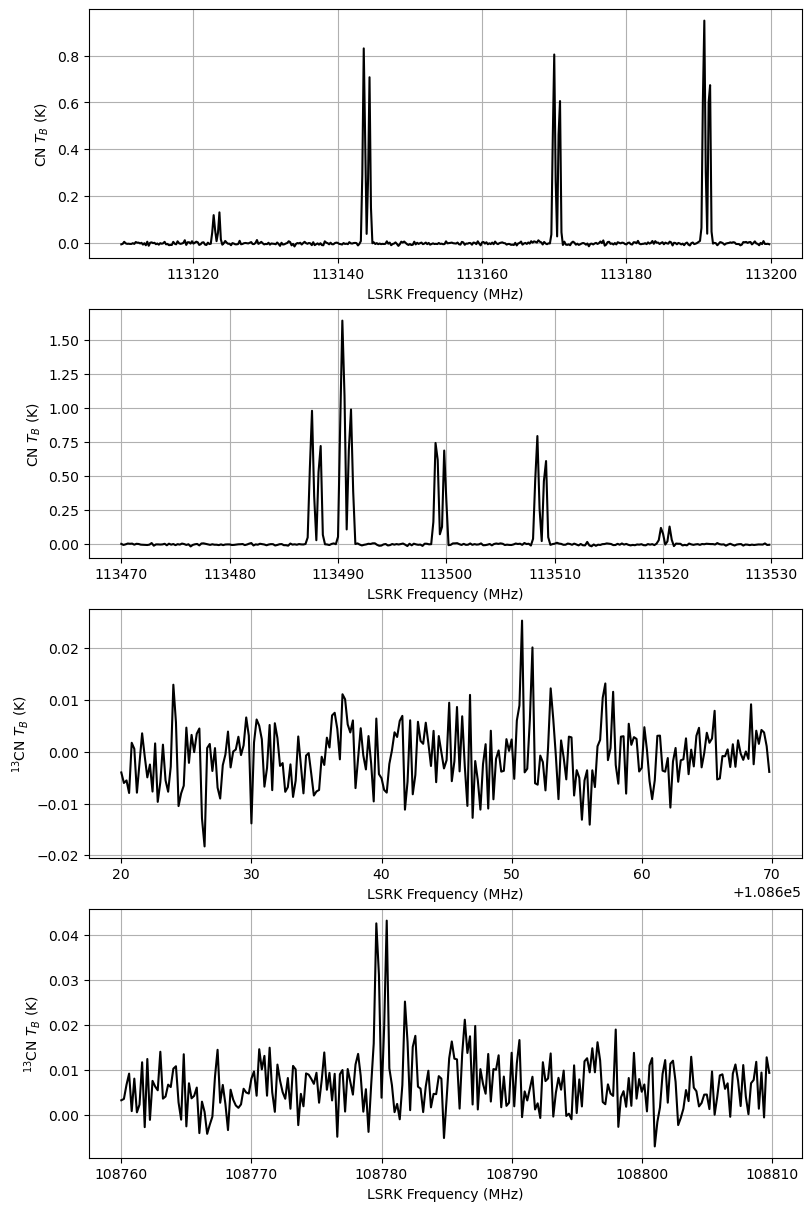

In [4]:
from bayes_spec import SpecData
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108760.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.005 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.5, 1.0], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N_12CN": [13.9, 13.8],
    "ratio_12C_13C": [65.0, 55.0],
    "log10_Tkin": [0.6, 0.7],
    "velocity": [-0.5, 1.5],
    "fwhm_nonthermal": [0.5, 0.75],
    "fwhm_L": 0.0,
    "baseline_12CN_norm": [0.0],
    "baseline_13CN_norm": [0.0],
}
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

derived_params = ["Tex_12CN", "Tex_13CN", "tau_12CN", "tau_13CN", "tau_total_12CN", "tau_total_13CN", "TR_12CN", "TR_13CN"]
derived_params = {
    param: model.model[param].eval(sim_params, on_unused_input="ignore")
    for param in derived_params
}

for key, value in derived_params.items():
    print()
    print(key)
    print(value)

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}
for label, dataset in data.items():
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Plot the simulated data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, dataset in enumerate(data.values()):
    axes[i].plot(dataset.spectral, dataset.brightness, 'k-')
    axes[i].set_ylabel(dataset.ylabel)
    _ = axes[i].set_xlabel(dataset.xlabel)

## Model Definition

In [5]:
# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.5, 1.0], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

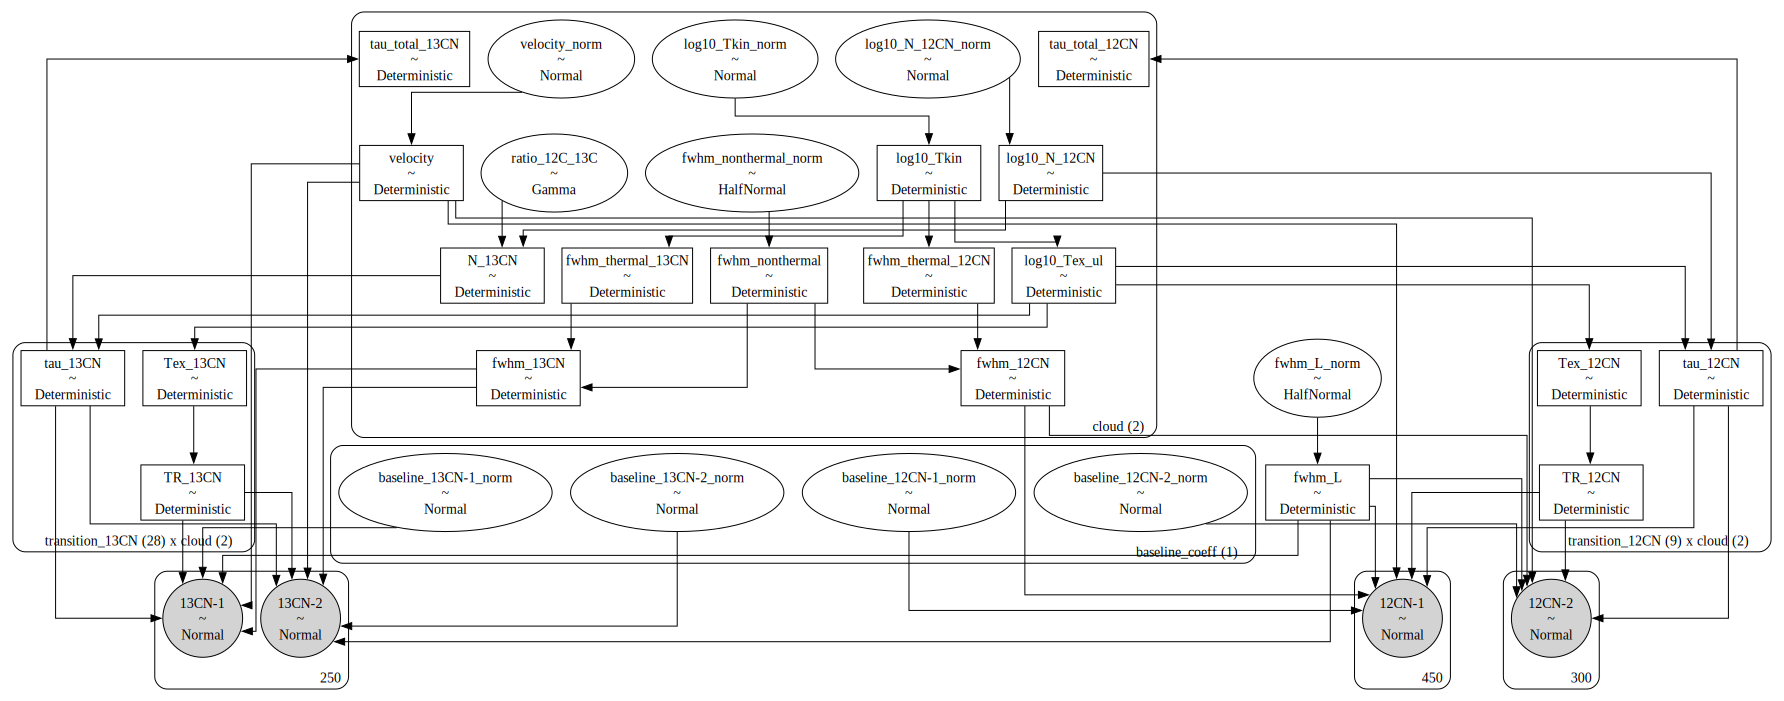

In [6]:
# Plot model graph
model.graph().render('cn_ratio_model', format='png')
model.graph()

In [7]:
# model string representation
print(model.model.str_repr())

baseline_12CN-1_norm ~ Normal(0, 1)
baseline_12CN-2_norm ~ Normal(0, 1)
baseline_13CN-1_norm ~ Normal(0, 1)
baseline_13CN-2_norm ~ Normal(0, 1)
       velocity_norm ~ Normal(0, 1)
     log10_Tkin_norm ~ Normal(0, 1)
fwhm_nonthermal_norm ~ HalfNormal(0, 1)
         fwhm_L_norm ~ HalfNormal(0, 1)
   log10_N_12CN_norm ~ Normal(0, 1)
       ratio_12C_13C ~ Gamma(9, f())
            velocity ~ Deterministic(f(velocity_norm))
          log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
   fwhm_thermal_12CN ~ Deterministic(f(log10_Tkin_norm))
   fwhm_thermal_13CN ~ Deterministic(f(log10_Tkin_norm))
     fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
           fwhm_12CN ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
           fwhm_13CN ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
              fwhm_L ~ Deterministic(f(fwhm_L_norm))
        log10_N_12CN ~ Deterministic(f(log10_N_12CN_norm))
              N_13CN ~ Deterministic(f(ratio_12C_13C, log10_N_12CN_norm))

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tkin_norm, ratio_12C_13C, velocity_norm]


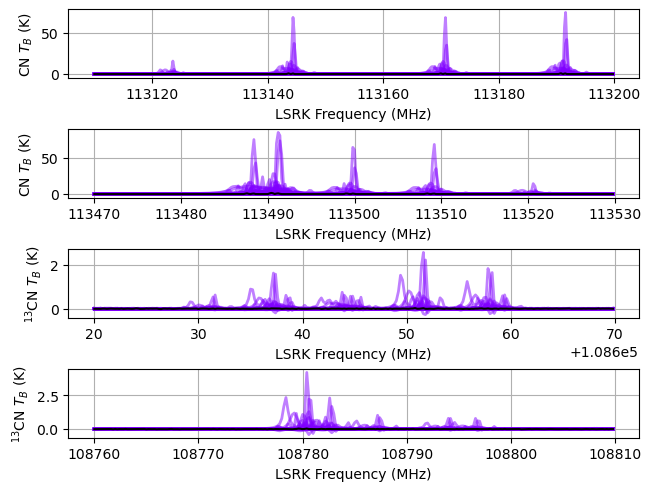

In [8]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [9]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5400
Interrupted at 5,399 [5%]: Average Loss = 1.4898e+05


Output()

Runtime: 2.15 minutes


In [10]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_freeRVs + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean            sd        hdi_3%  \
velocity[0]              1.501000e+00  1.000000e-03  1.499000e+00   
velocity[1]             -4.950000e-01  2.000000e-03 -4.980000e-01   
log10_Tkin[0]            7.020000e-01  1.000000e-03  7.010000e-01   
log10_Tkin[1]            5.980000e-01  1.000000e-03  5.970000e-01   
fwhm_thermal_12CN[0]     9.400000e-02  0.000000e+00  9.400000e-02   
fwhm_thermal_12CN[1]     8.400000e-02  0.000000e+00  8.300000e-02   
fwhm_thermal_13CN[0]     9.200000e-02  0.000000e+00  9.200000e-02   
fwhm_thermal_13CN[1]     8.200000e-02  0.000000e+00  8.200000e-02   
fwhm_nonthermal[0]       7.460000e-01  3.000000e-03  7.410000e-01   
fwhm_nonthermal[1]       4.870000e-01  3.000000e-03  4.820000e-01   
fwhm_12CN[0]             7.520000e-01  2.000000e-03  7.470000e-01   
fwhm_12CN[1]             4.950000e-01  3.000000e-03  4.890000e-01   
fwhm_13CN[0]             7.520000e-01  2.000000e-03  7.470000e-01   
fwhm_13CN[1]             4.940000e-01  3.000000e-03  4.890000e-01   
log10_N_12CN[0]          1.380300e+01  1.000000e-03  1.380100e+01   
log10_N_12CN[1]          1.390700e+01  3.000000e-03  1.390200e+01   
N_13CN[0]                1.162324e+12  9.349491e+10  1.001947e+12   
N_13CN[1]                1.232227e+12  1.283326e+11  9.989166e+11   
log10_Tex_ul[0]          7.020000e-01  1.000000e-03  7.010000e-01   
log10_Tex_ul[1]          5.980000e-01  1.000000e-03  5.970000e-01   
tau_total_12CN[0]        2.037000e+00  7.000000e-03  2.023000e+00   
tau_total_12CN[1]        3.352000e+00  2.200000e-02  3.311000e+00   
tau_total_13CN[0]        3.400000e-02  3.000000e-03  3.000000e-02   
tau_total_13CN[1]        4.700000e-02  5.000000e-03  3.800000e-02   
fwhm_L_norm              6.000000e-03  1.000000e-03  4.000000e-03   
fwhm_L                   6.000000e-03  1.000000e-03  4.000000e-03   
baseline_12CN-1_norm[0] -5.000000e-02  5.100000e-02 -1.400000e-01   
baseline_12CN-2_norm[0] -2.480000e-01  6.100000e-02 -3.670000e-01   
baseline_13CN-1_norm[0] -2.000000e-01  6.900000e-02 -3.210000e-01   
baseline_13CN-2_norm[0] -4.800000e-02  7.000000e-02 -1.740000e-01   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]              1.504000e+00  0.000000e+00  0.000000e+00     937.0   
velocity[1]             -4.920000e-01  0.000000e+00  0.000000e+00     963.0   
log10_Tkin[0]            7.040000e-01  0.000000e+00  0.000000e+00    1002.0   
log10_Tkin[1]            5.990000e-01  0.000000e+00  0.000000e+00     929.0   
fwhm_thermal_12CN[0]     9.400000e-02  0.000000e+00  0.000000e+00    1002.0   
fwhm_thermal_12CN[1]     8.400000e-02  0.000000e+00  0.000000e+00     929.0   
fwhm_thermal_13CN[0]     9.300000e-02  0.000000e+00  0.000000e+00    1002.0   
fwhm_thermal_13CN[1]     8.200000e-02  0.000000e+00  0.000000e+00     929.0   
fwhm_nonthermal[0]       7.510000e-01  0.000000e+00  0.000000e+00     957.0   
fwhm_nonthermal[1]       4.930000e-01  0.000000e+00  0.000000e+00    1021.0   
fwhm_12CN[0]             7.570000e-01  0.000000e+00  0.000000e+00     956.0   
fwhm_12CN[1]             5.000000e-01  0.000000e+00  0.000000e+00    1021.0   
fwhm_13CN[0]             7.560000e-01  0.000000e+00  0.000000e+00     956.0   
fwhm_13CN[1]             5.000000e-01  0.000000e+00  0.000000e+00    1021.0   
log10_N_12CN[0]          1.380600e+01  0.000000e+00  0.000000e+00     967.0   
log10_N_12CN[1]          1.391200e+01  0.000000e+00  0.000000e+00     872.0   
N_13CN[0]                1.346319e+12  3.180590e+09  2.254144e+09     885.0   
N_13CN[1]                1.468115e+12  3.980929e+09  2.821203e+09    1041.0   
log10_Tex_ul[0]          7.040000e-01  0.000000e+00  0.000000e+00    1002.0   
log10_Tex_ul[1]          5.990000e-01  0.000000e+00  0.000000e+00     929.0   
tau_total_12CN[0]        2.051000e+00  0.000000e+00  0.000000e+00    1025.0   
tau_total_12CN[1]        3.393000e+00  1.000000e-03  1.000000e-03     895.0   
tau_total_13CN[0]        4.000000e-02  0.000000e+00  0.000000e+00     870.0 

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

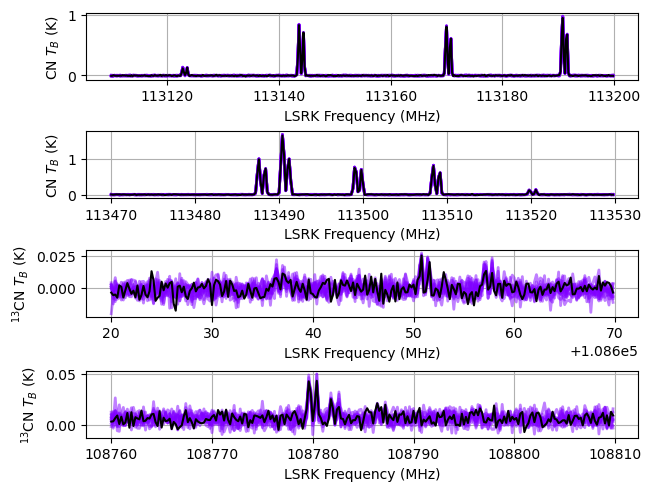

In [11]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [12]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5400
Interrupted at 5,399 [5%]: Average Loss = 1.4898e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 266 seconds.


Adding log-likelihood to trace


Output()

Runtime: 7.42 minutes


In [13]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [14]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean            sd        hdi_3%  \
velocity[0]              1.501000e+00  1.000000e-03  1.499000e+00   
velocity[1]             -5.000000e-01  1.000000e-03 -5.020000e-01   
log10_Tkin[0]            7.010000e-01  1.000000e-03  6.990000e-01   
log10_Tkin[1]            5.980000e-01  1.000000e-03  5.970000e-01   
fwhm_thermal_12CN[0]     9.400000e-02  0.000000e+00  9.400000e-02   
fwhm_thermal_12CN[1]     8.400000e-02  0.000000e+00  8.300000e-02   
fwhm_thermal_13CN[0]     9.200000e-02  0.000000e+00  9.200000e-02   
fwhm_thermal_13CN[1]     8.200000e-02  0.000000e+00  8.200000e-02   
fwhm_nonthermal[0]       7.500000e-01  3.000000e-03  7.450000e-01   
fwhm_nonthermal[1]       4.900000e-01  3.000000e-03  4.840000e-01   
fwhm_12CN[0]             7.560000e-01  3.000000e-03  7.510000e-01   
fwhm_12CN[1]             4.970000e-01  3.000000e-03  4.910000e-01   
fwhm_13CN[0]             7.560000e-01  3.000000e-03  7.510000e-01   
fwhm_13CN[1]             4.970000e-01  3.000000e-03  4.910000e-01   
log10_N_12CN[0]          1.380000e+01  3.000000e-03  1.379500e+01   
log10_N_12CN[1]          1.390700e+01  4.000000e-03  1.390000e+01   
N_13CN[0]                1.164593e+12  9.063165e+10  9.942768e+11   
N_13CN[1]                1.221296e+12  1.163163e+11  1.003880e+12   
log10_Tex_ul[0]          7.010000e-01  1.000000e-03  6.990000e-01   
log10_Tex_ul[1]          5.980000e-01  1.000000e-03  5.970000e-01   
tau_total_12CN[0]        2.030000e+00  1.700000e-02  1.999000e+00   
tau_total_12CN[1]        3.350000e+00  3.500000e-02  3.285000e+00   
tau_total_13CN[0]        3.400000e-02  3.000000e-03  2.900000e-02   
tau_total_13CN[1]        4.600000e-02  4.000000e-03  3.800000e-02   
fwhm_L                   5.000000e-03  3.000000e-03  0.000000e+00   
baseline_12CN-1_norm[0] -4.600000e-02  4.900000e-02 -1.400000e-01   
baseline_12CN-2_norm[0] -2.460000e-01  6.200000e-02 -3.590000e-01   
baseline_13CN-1_norm[0] -1.920000e-01  6.600000e-02 -3.160000e-01   
baseline_13CN-2_norm[0] -6.700000e-02  6.400000e-02 -1.840000e-01   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]              1.502000e+00  0.000000e+00  0.000000e+00   12607.0   
velocity[1]             -4.980000e-01  0.000000e+00  0.000000e+00   12472.0   
log10_Tkin[0]            7.030000e-01  0.000000e+00  0.000000e+00    8012.0   
log10_Tkin[1]            6.000000e-01  0.000000e+00  0.000000e+00    8462.0   
fwhm_thermal_12CN[0]     9.400000e-02  0.000000e+00  0.000000e+00    8012.0   
fwhm_thermal_12CN[1]     8.400000e-02  0.000000e+00  0.000000e+00    8462.0   
fwhm_thermal_13CN[0]     9.200000e-02  0.000000e+00  0.000000e+00    8012.0   
fwhm_thermal_13CN[1]     8.200000e-02  0.000000e+00  0.000000e+00    8462.0   
fwhm_nonthermal[0]       7.550000e-01  0.000000e+00  0.000000e+00    8246.0   
fwhm_nonthermal[1]       4.960000e-01  0.000000e+00  0.000000e+00    8560.0   
fwhm_12CN[0]             7.610000e-01  0.000000e+00  0.000000e+00    8230.0   
fwhm_12CN[1]             5.030000e-01  0.000000e+00  0.000000e+00    8549.0   
fwhm_13CN[0]             7.610000e-01  0.000000e+00  0.000000e+00    8230.0   
fwhm_13CN[1]             5.030000e-01  0.000000e+00  0.000000e+00    8549.0   
log10_N_12CN[0]          1.380500e+01  0.000000e+00  0.000000e+00    7682.0   
log10_N_12CN[1]          1.391400e+01  0.000000e+00  0.000000e+00    7737.0   
N_13CN[0]                1.334397e+12  8.407553e+08  5.945187e+08   11572.0   
N_13CN[1]                1.437181e+12  1.050879e+09  7.431013e+08   12233.0   
log10_Tex_ul[0]          7.030000e-01  0.000000e+00  0.000000e+00    8012.0   
log10_Tex_ul[1]          6.000000e-01  0.000000e+00  0.000000e+00    8462.0   
tau_total_12CN[0]        2.062000e+00  0.000000e+00  0.000000e+00    7761.0   
tau_total_12CN[1]        3.416000e+00  0.000000e+00  0.000000e+00    7827.0   
tau_total_13CN[0]        3.900000e-02  0.000000e+00  0.000000e+00   11586.0   
tau_total_13CN[1]        5.500000e-02  0.000000e+00  0.000000e+00 

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

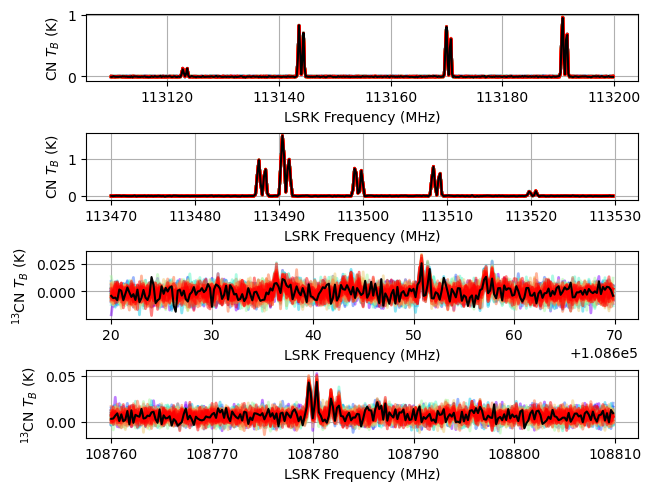

In [15]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

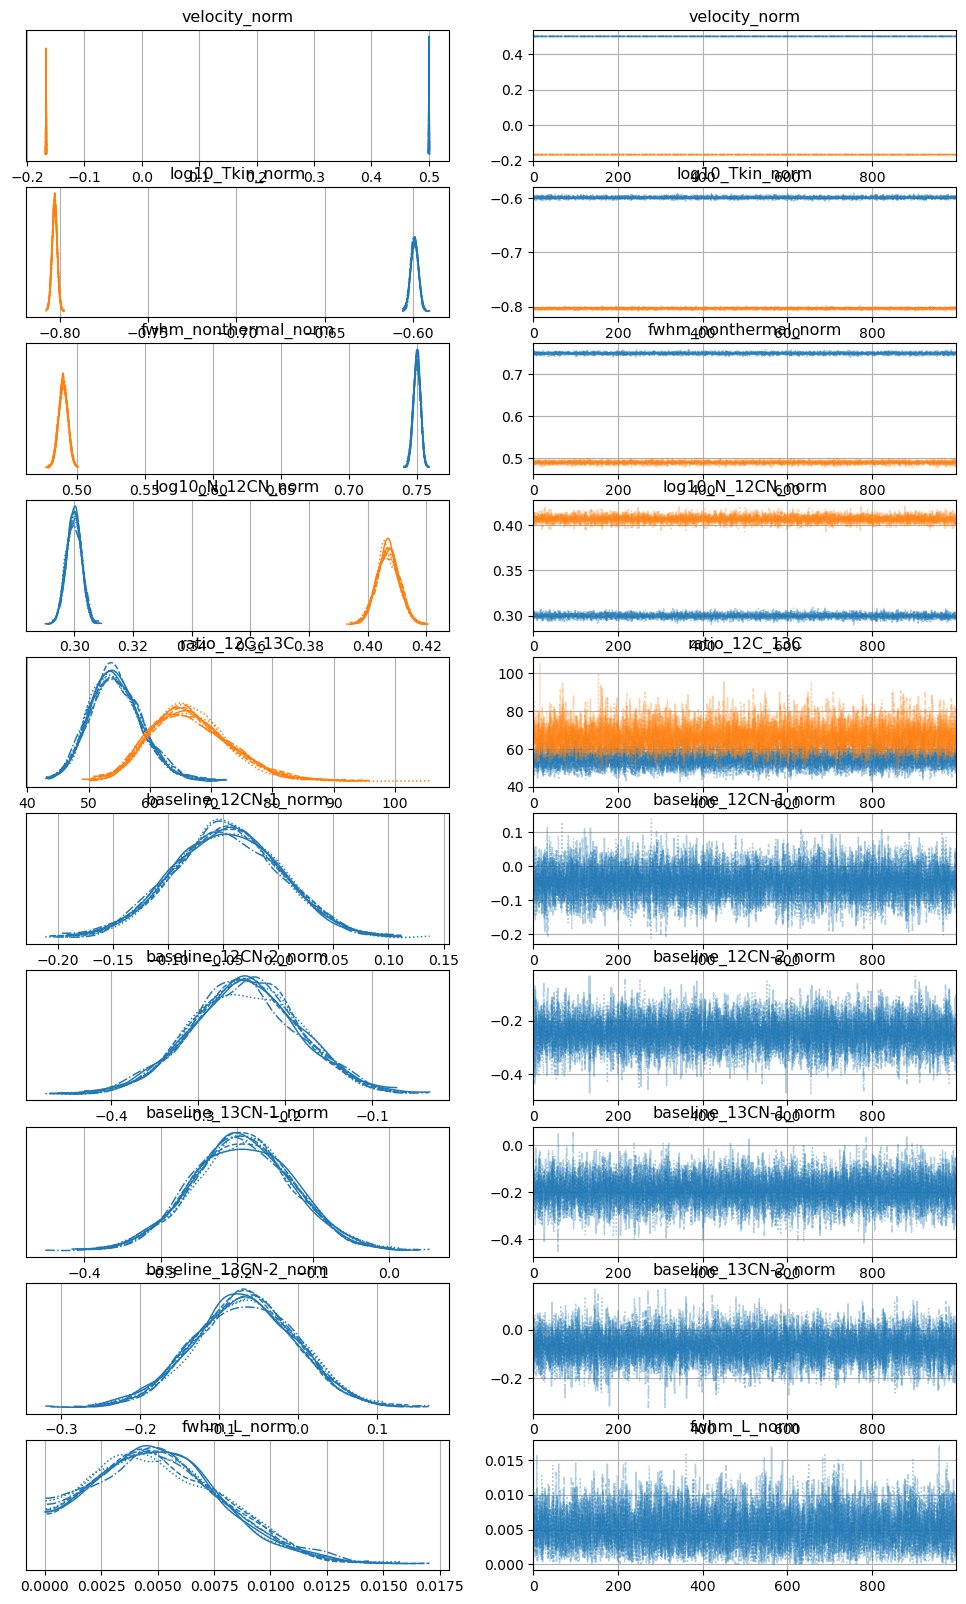

In [16]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

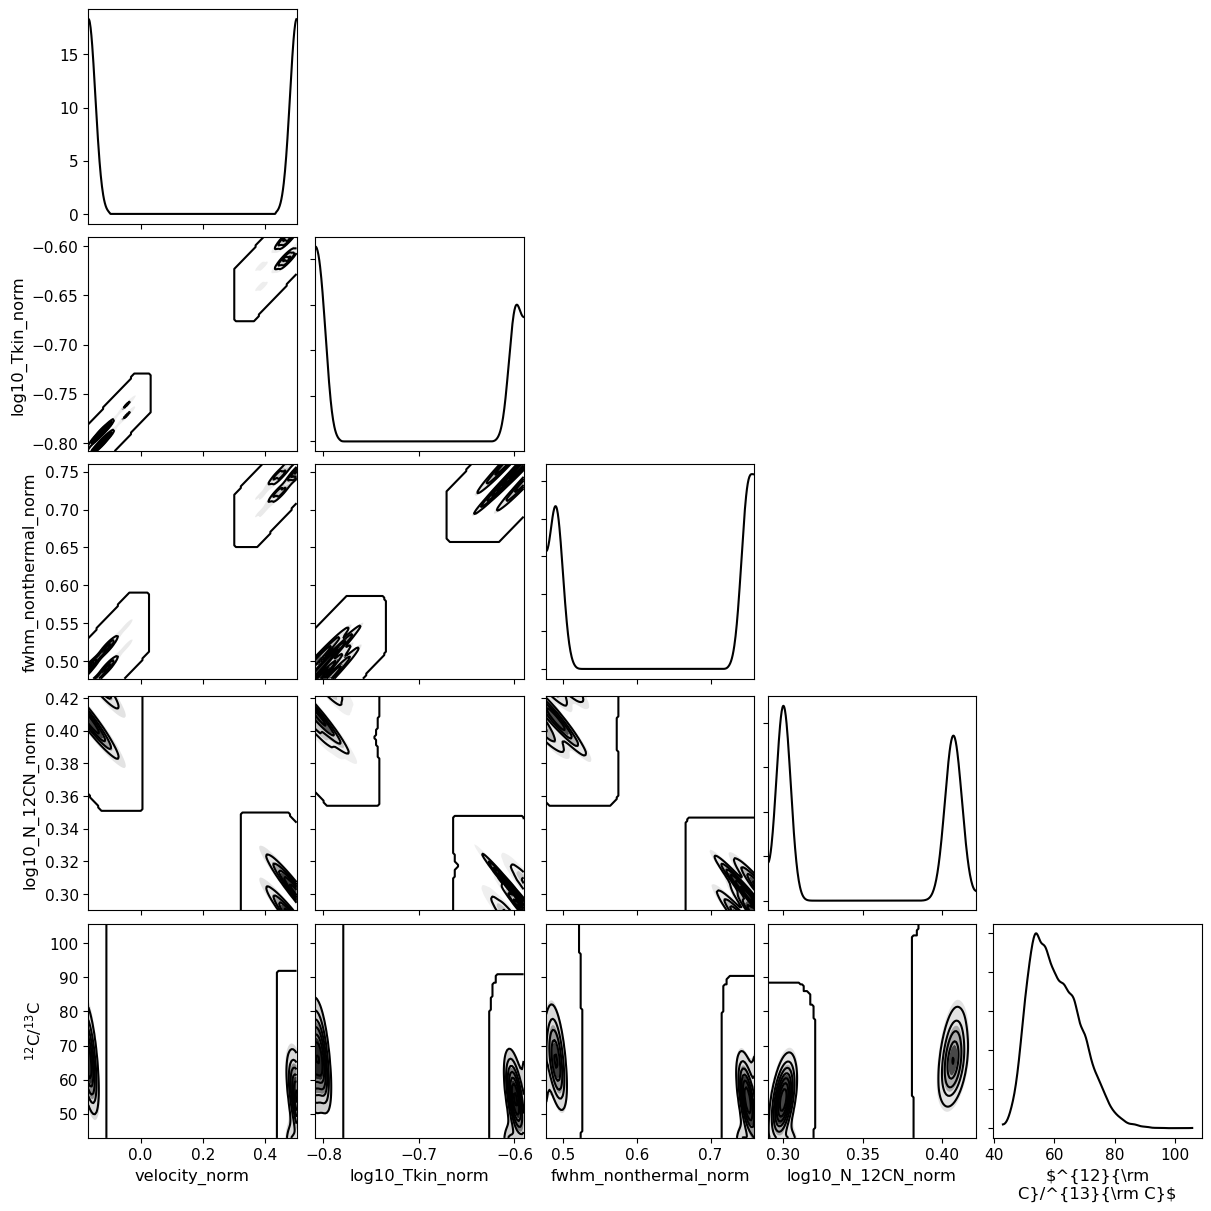

In [17]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

['velocity', 'log10_Tkin', 'fwhm_thermal_12CN', 'fwhm_thermal_13CN', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN']


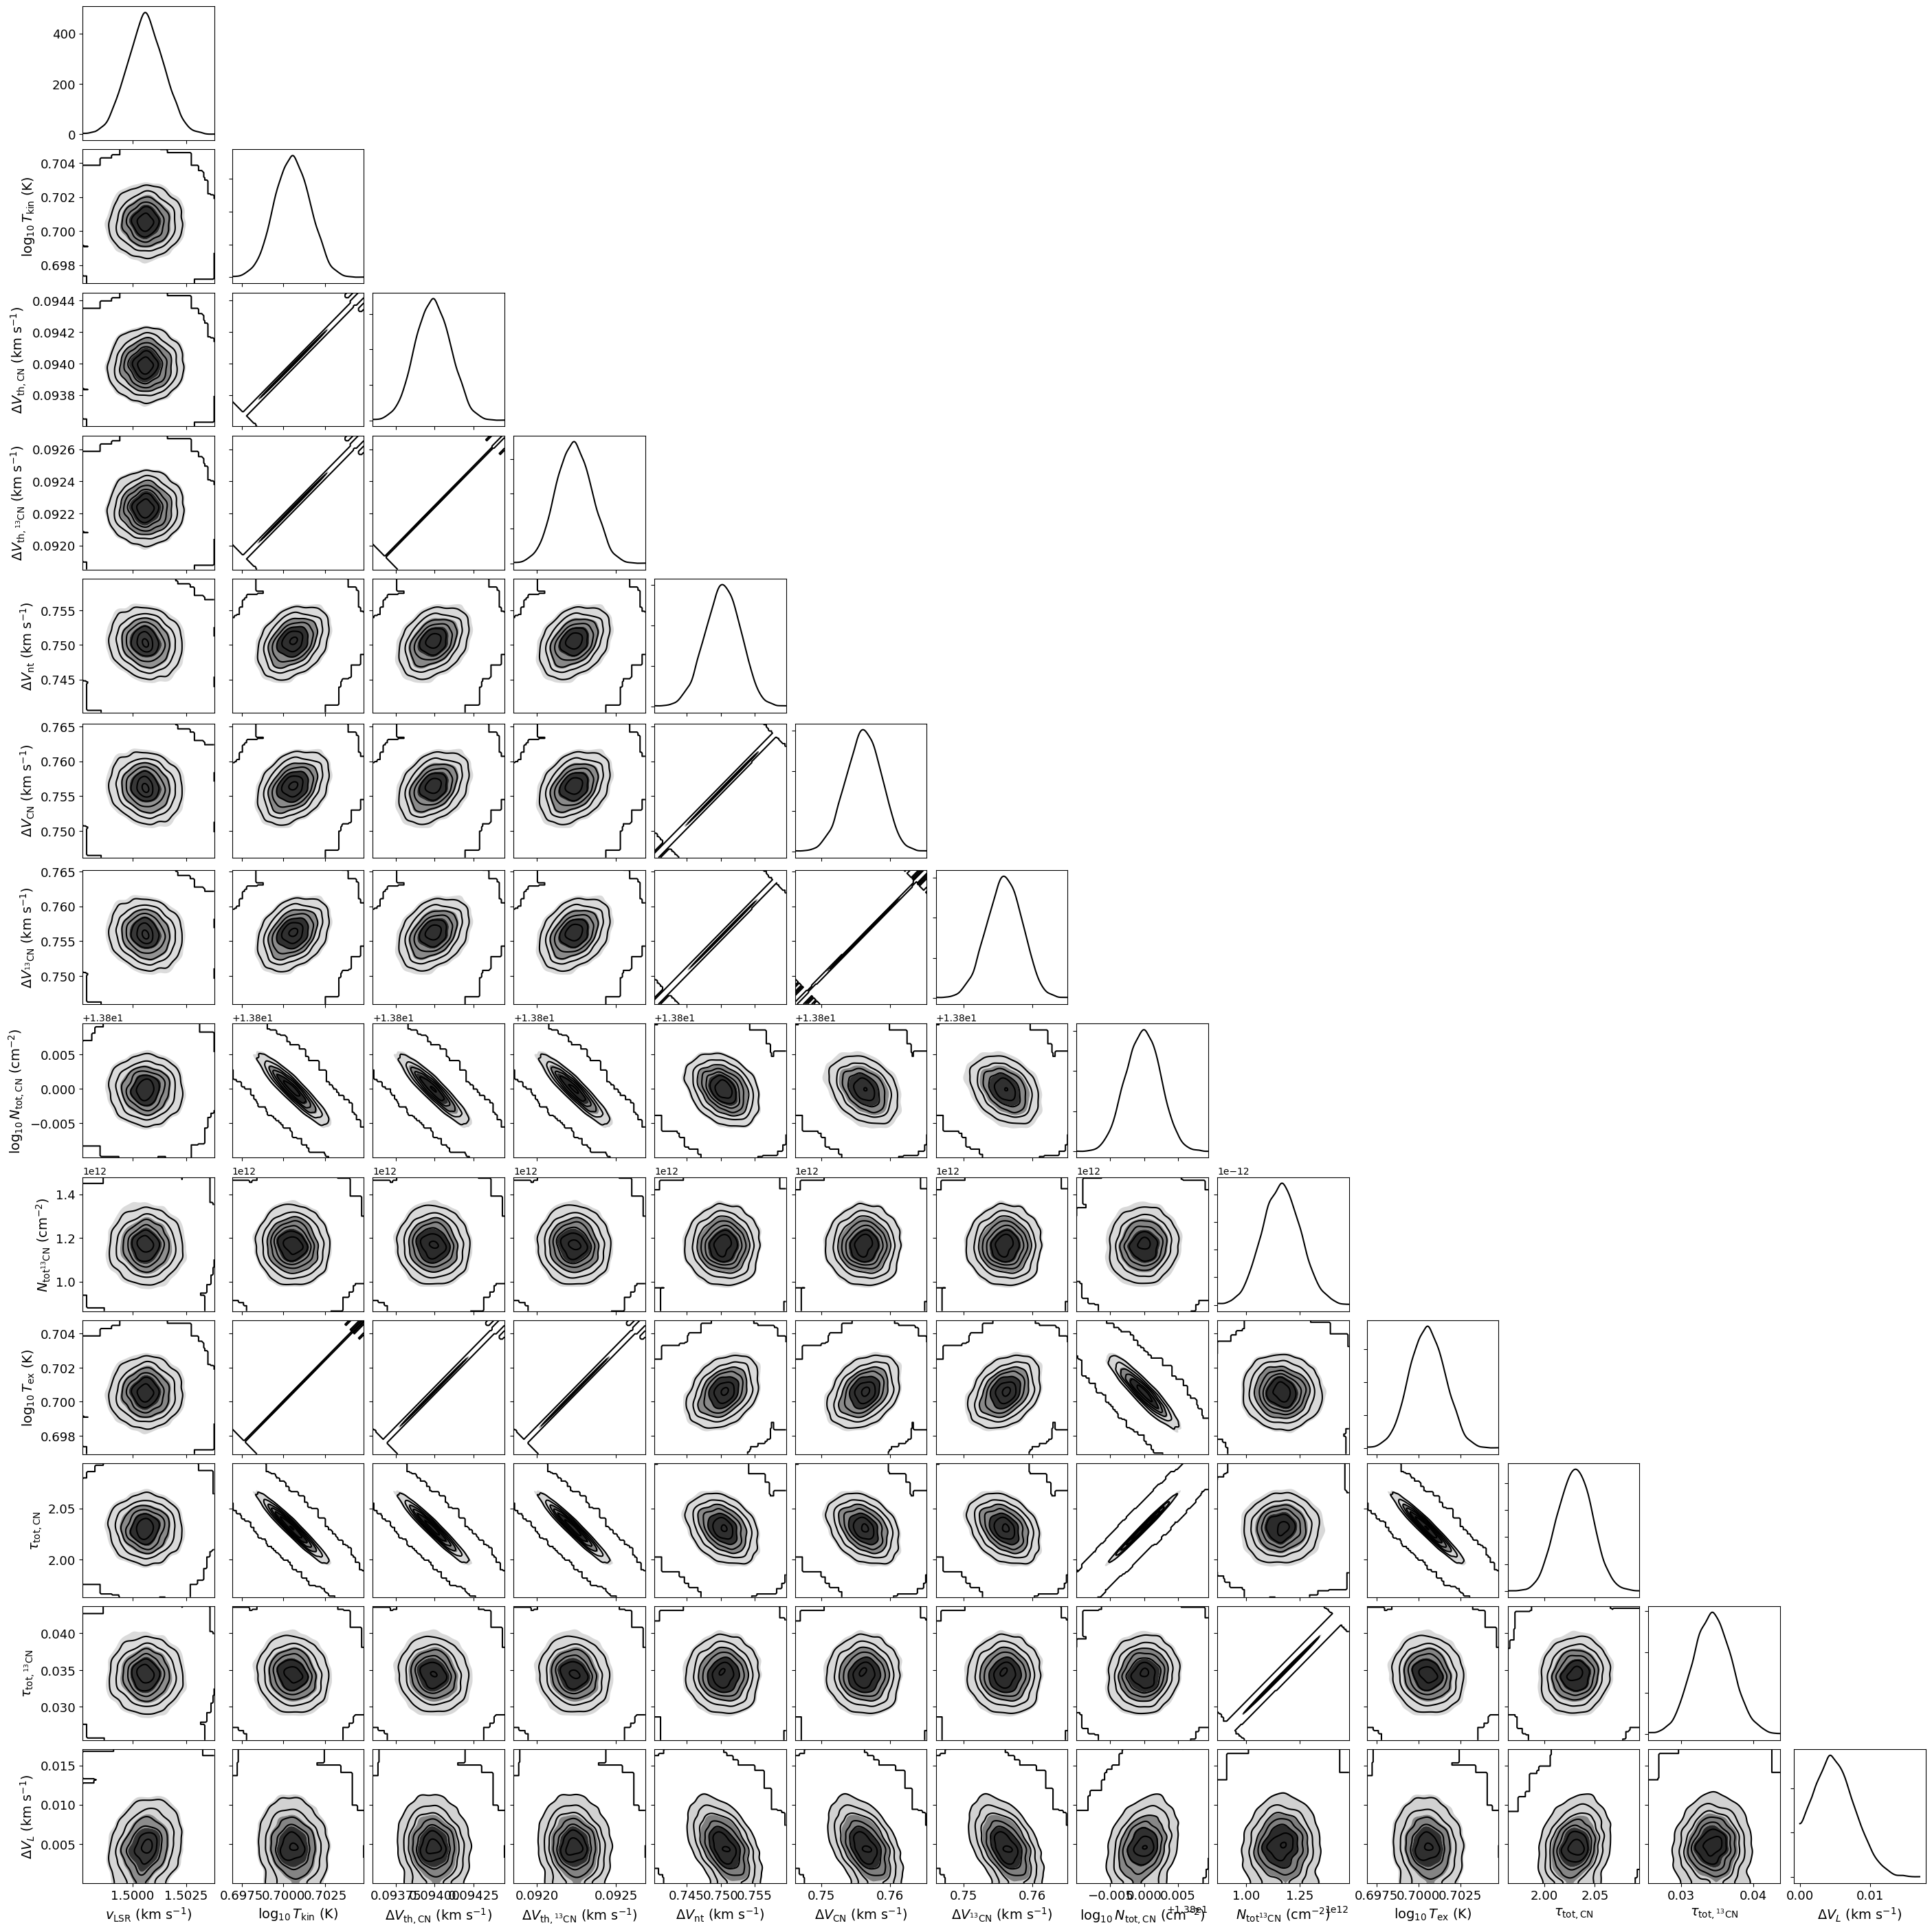

In [18]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

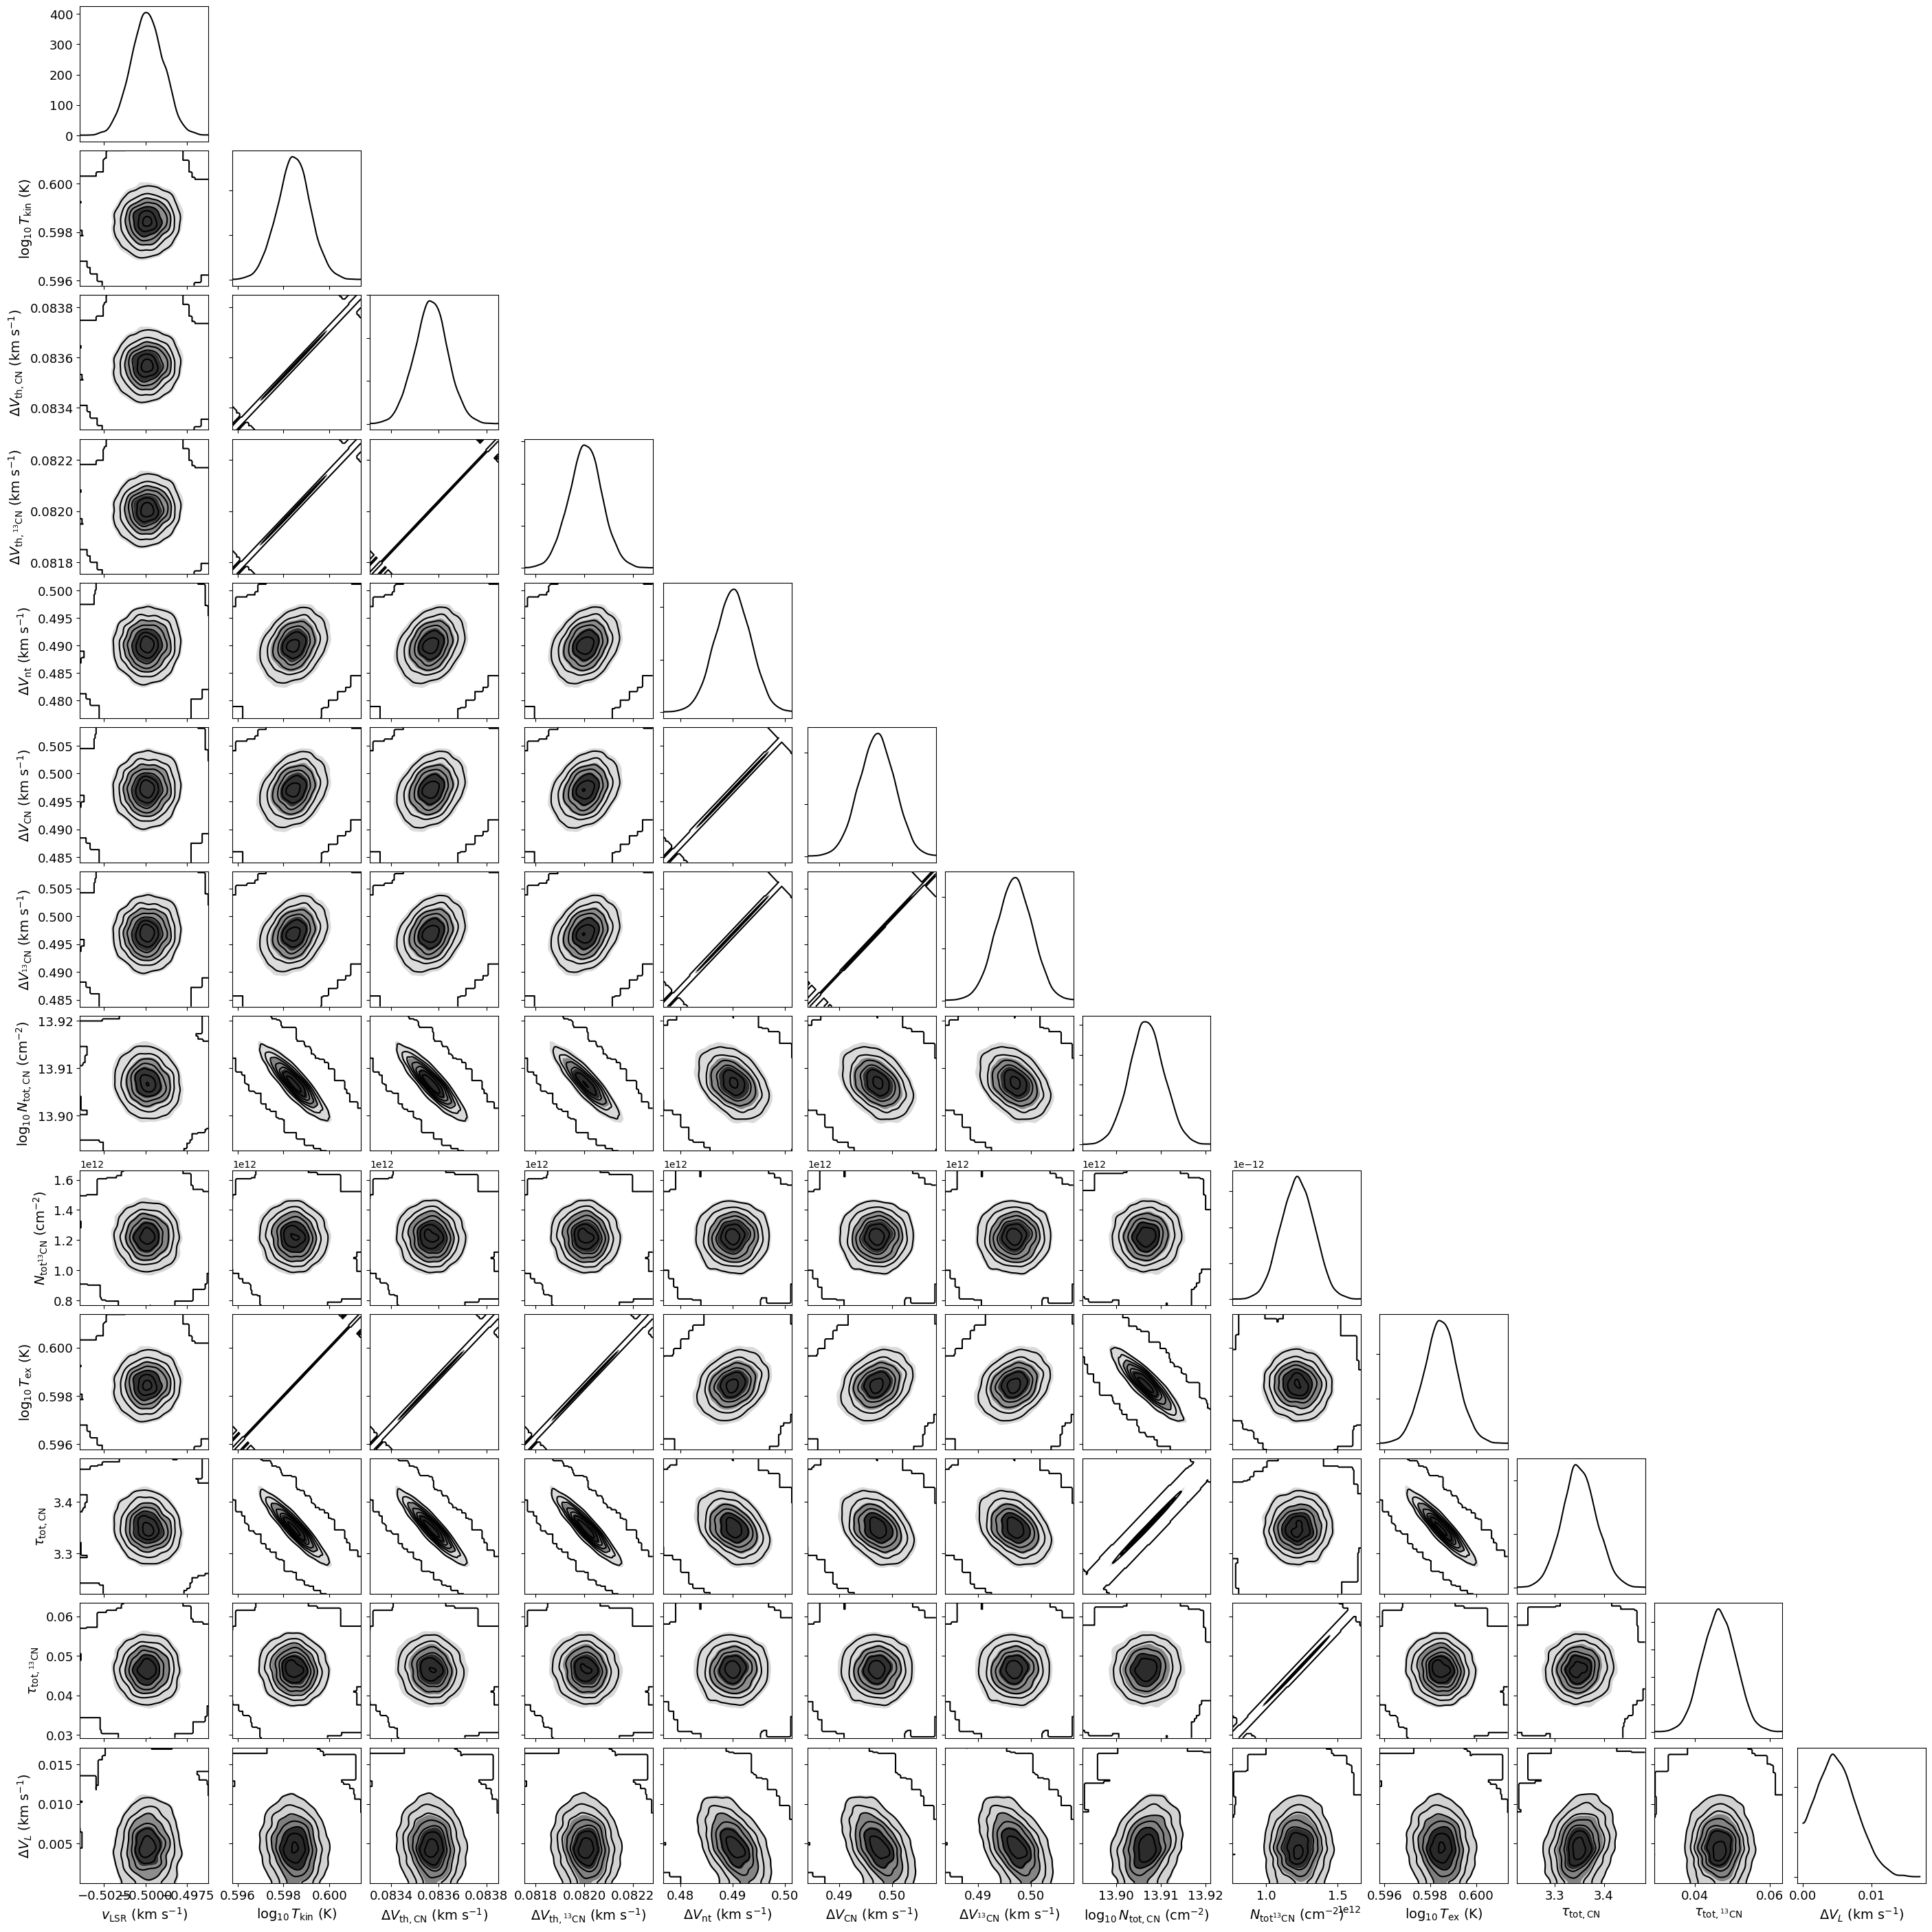

In [19]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [23]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_freeRVs + model.hyper_deterministics + ["ratio_12C_13C"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -9641.039993203709


mean            sd       hdi_16%  \
velocity[0]               1.501000e+00  1.000000e-03  1.500000e+00   
velocity[1]              -5.000000e-01  1.000000e-03 -5.010000e-01   
log10_Tkin[0]             7.010000e-01  1.000000e-03  7.000000e-01   
log10_Tkin[1]             5.980000e-01  1.000000e-03  5.980000e-01   
fwhm_thermal_12CN[0]      9.400000e-02  0.000000e+00  9.400000e-02   
fwhm_thermal_12CN[1]      8.400000e-02  0.000000e+00  8.400000e-02   
fwhm_thermal_13CN[0]      9.200000e-02  0.000000e+00  9.200000e-02   
fwhm_thermal_13CN[1]      8.200000e-02  0.000000e+00  8.200000e-02   
fwhm_nonthermal[0]        7.500000e-01  3.000000e-03  7.480000e-01   
fwhm_nonthermal[1]        4.900000e-01  3.000000e-03  4.870000e-01   
fwhm_12CN[0]              7.560000e-01  3.000000e-03  7.540000e-01   
fwhm_12CN[1]              4.970000e-01  3.000000e-03  4.940000e-01   
fwhm_13CN[0]              7.560000e-01  3.000000e-03  7.540000e-01   
fwhm_13CN[1]              4.970000e-01  3.000000e-03  4.940000e-01   
log10_N_12CN[0]           1.380000e+01  3.000000e-03  1.379700e+01   
log10_N_12CN[1]           1.390700e+01  4.000000e-03  1.390300e+01   
N_13CN[0]                 1.164593e+12  9.063165e+10  1.079227e+12   
N_13CN[1]                 1.221296e+12  1.163163e+11  1.110839e+12   
log10_Tex_ul[0]           7.010000e-01  1.000000e-03  7.000000e-01   
log10_Tex_ul[1]           5.980000e-01  1.000000e-03  5.980000e-01   
Tex_12CN[113123.3687, 0]  5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113123.3687, 1]  3.967000e+00  7.000000e-03  3.961000e+00   
Tex_12CN[113144.19, 0]    5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113144.19, 1]    3.967000e+00  7.000000e-03  3.961000e+00   
Tex_12CN[113170.535, 0]   5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113170.535, 1]   3.967000e+00  7.000000e-03  3.961000e+00   
Tex_12CN[113191.325, 0]   5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113191.325, 1]   3.967000e+00  7.000000e-03  3.961000e+00   
Tex_12CN[113488.142, 0]   5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113488.142, 1]   3.967000e+00  7.000000e-03  3.961000e+00   
Tex_12CN[113490.985, 0]   5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113490.985, 1]   3.967000e+00  7.000000e-03  3.961000e+00   
Tex_12CN[113499.643, 0]   5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113499.643, 1]   3.967000e+00  7.000000e-03  3.961000e+00   
Tex_12CN[113508.934, 0]   5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113508.934, 1]   3.967000e+00  7.000000e-03  3.961000e+00   
Tex_12CN[113520.4215, 0]  5.018000e+00  1.200000e-02  5.005000e+00   
Tex_12CN[113520.4215, 1]  3.967000e+00  7.000000e-03  3.961000e+00   
tau_12CN[113123.3687, 0]  2.400000e-02  0.000000e+00  2.400000e-02   
tau_12CN[113123.3687, 1]  4.000000e-02  0.000000e+00  4.000000e-02   
tau_12CN[113144.19, 0]    2.000000e-01  2.000000e-03  1.990000e-01   
tau_12CN[113144.19, 1]    3.310000e-01  3.000000e-03  3.270000e-01   
tau_12CN[113170.535, 0]   1.960000e-01  2.000000e-03  1.940000e-01   
tau_12CN[113170.535, 1]   3.230000e-01  3.000000e-03  3.200000e-01   
tau_12CN[113191.325, 0]   2.540000e-01  2.000000e-03  2.520000e-01   
tau_12CN[113191.325, 1]   4.190000e-01  4.000000e-03  4.150000e-01   
tau_12CN[113488.142, 0]   2.550000e-01  2.000000e-03  2.530000e-01   
tau_12CN[113488.142, 1]   4.210000e-01  4.000000e-03  4.170000e-01   
tau_12CN[113490.985, 0]   6.780000e-01  6.000000e-03  6.720000e-01   
tau_12CN[113490.985, 1]   1.118000e+00  1.200000e-02  1.107000e+00   
tau_12CN[113499.643, 0]   2.010000e-01  2.000000e-03  2.000000e-01   
tau_12CN[113499.643, 1]   3.320000e-01  3.000000e-03  3.290000e-01   
tau_12CN[113508.934, 0]   1.970000e-01  2.000000e-03  1.950000e-01   
tau_12CN[113508.934, 1]   3.250000e-01  3.000000e-03  3.210000e-01   
tau_12CN[113520.4215, 0]  2.500000e-02  0.000000e+00  2.400000e-02   
tau_12CN[113520.4215, 1]  4.100000e-02  0.000000e+00  4.000000e-02   
tau_total_12CN[0]         2.030000e+00  1.70

In [21]:
print(sim_params)
print(derived_params)

{'log10_N_12CN': [13.9, 13.8], 'ratio_12C_13C': [65.0, 55.0], 'log10_Tkin': [0.6, 0.7], 'velocity': [-0.5, 1.5], 'fwhm_nonthermal': [0.5, 0.75], 'fwhm_L': 0.0, 'baseline_12CN_norm': [0.0], 'baseline_13CN_norm': [0.0]}
{'Tex_12CN': array([[3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234]]), 'Tex_13CN': array([[3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.01187234],
       [3.98107171, 5.0118723